Thai N-NER: Thai Nested Named Entity Recognition
This demo notebook provides a tutorial on using Thai N-NER, with references from Thai N-NER

Learn more about Thai N-NER here : Thai N-NER

In [1]:
!wandb login 

wandb: Currently logged in as: eieizdy007 (eieizdy007-thammasat-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
import wandb
from huggingface_hub import notebook_login
from datasets import load_dataset
import numpy as np
import numpy.random
import torch

from tqdm.auto import tqdm
from functools import partial

d:\mini\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#transformers
from transformers import (
    CamembertTokenizer,
    AutoTokenizer,
    AutoModel,
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)

#thaixtransformers
from thaixtransformers import Tokenizer
from thaixtransformers.preprocess import process_transformers

In [53]:
orchid = load_dataset("Thichow/orchid_corpus", trust_remote_code=True) #from hugging face 

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'Thichow/orchid_corpus' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
Using the latest cached version of the dataset since Thichow/orchid_corpus couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'thai_orchid_dataset' at C:\Users\eieiz\.cache\huggingface\datasets\Thichow___orchid_corpus\thai_orchid_dataset\1.0.0\adc51c330b524a9226a122393a9ebb1dbaf80c33c5a2a0d84219e9339ae292c0 (last modified on Sat Aug 16 17:16:47 2025).


In [38]:
orchid['train'][0]

{'id': '0',
 'label_tokens': ['การ', 'ประชุม', 'ทาง', 'วิชาการ', ' ', 'ครั้ง', 'ที่ 1'],
 'pos_tags': [21, 39, 26, 26, 37, 4, 18],
 'sentence': 'การประชุมทางวิชาการ ครั้งที่ 1'}

In [7]:
len(orchid["train"].features["pos_tags"].feature.names)

47

wangchanberta-base-att-spm-uncased (recommended) - Largest WangchanBERTa    trained on 78.5GB of Assorted Thai Texts with subword tokenizer SentencePiece  
xlm-roberta-base - Facebook's XLMR trained on 100 languages   
bert-base-multilingual-cased - Google's mBERT trained on 104 languages  
wangchanberta-base-wiki-newmm - WangchanBERTa trained on Thai Wikipedia Dump   with PyThaiNLP's word-level tokenizer newmm  
wangchanberta-base-wiki-syllable - WangchanBERTa trained on Thai Wikipedia   Dump with PyThaiNLP's syllabel-level tokenizer syllable  
wangchanberta-base-wiki-sefr - WangchanBERTa trained on Thai Wikipedia Dump  with word-level tokenizer SEFR 
wangchanberta-base-wiki-spm - WangchanBERTa trained on Thai Wikipedia Dump  with subword-level tokenizer SentencePiece  
In the first part, we require you to select the   wangchanberta-base-att-spm-uncased.  

## Tokenizer

In [8]:
model_names = [
    'airesearch/wangchanberta-base-att-spm-uncased',
    'airesearch/wangchanberta-base-wiki-newmm',
    'airesearch/wangchanberta-base-wiki-ssg',
    'airesearch/wangchanberta-base-wiki-sefr',
    'airesearch/wangchanberta-base-wiki-spm',
]

model_name = model_names[0]


In [41]:
tokenizer = AutoTokenizer.from_pretrained(
                                  'airesearch/wangchanberta-base-att-spm-uncased',
                                  revision='main',
                                  model_max_length=416)

# tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")
# print(len(tokenizer)) 

len(tokenizer)

25004

In [42]:
text = 'ศิลปะไม่เป็นเจ้านายใคร และไม่เป็นขี้ข้าใคร'
print('text :', text)

text : ศิลปะไม่เป็นเจ้านายใคร และไม่เป็นขี้ข้าใคร


In [11]:
tokenizer([text])

{'input_ids': [[5, 10, 2391, 1501, 5365, 197, 222, 1501, 21325, 197, 6]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [16]:
# tokenizer('ฉัน') [5, 264, 6]
tokenizer.decode(5),tokenizer.decode(264),tokenizer.decode(6)

('<s>', 'ฉัน', '</s>')

In [17]:
tokens = []
for i in tokenizer([text], is_split_into_words=True)['input_ids']:
  tokens.append(tokenizer.decode(i))
print('tokens :', tokens)

tokens : ['<s>', '', 'ศิลปะ', 'ไม่เป็น', 'เจ้านาย', 'ใคร', 'และ', 'ไม่เป็น', 'ขี้ข้า', 'ใคร', '</s>']


In [ ]:
example = orchid["train"][0]
for i in example:
    print(i, ':', example[i])

id : 0
label_tokens : ['การ', 'ประชุม', 'ทาง', 'วิชาการ', ' ', 'ครั้ง', 'ที่ 1']
pos_tags : [21, 39, 26, 26, 37, 4, 18]
sentence : การประชุมทางวิชาการ ครั้งที่ 1


In [ ]:
text = 'การประชุมทางวิชาการ ครั้งที่ 1'
tokenizer(text)

{'input_ids': [5, 10, 882, 8222, 10, 1014, 10, 59, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
for i in tokenizer(text)['input_ids']:
  print(tokenizer.convert_ids_to_tokens(i))

<s>
▁
การประชุม
ทางวิชาการ
▁
ครั้งที่
▁
1
</s>


In [21]:
example = orchid["train"][1899]
print('sentence :', example["sentence"])
tokenized_input = tokenizer([example["sentence"]], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

print('tokens :',tokens)
print('label tokens :', example["label_tokens"])
print('label pos :', example["pos_tags"])

sentence : โดยพิจารณาจากพจนานุกรมภาษาคู่ (Bilingual transfer dictionary)
tokens : ['<s>', '▁โดย', 'พิจารณาจาก', 'พจนานุกรม', 'ภาษา', 'คู่', '▁(', '<unk>', 'i', 'ling', 'ual', '▁', 'trans', 'fer', '▁', 'di', 'ction', 'ary', ')', '</s>']
label tokens : ['โดย', 'พิจารณา', 'จาก', 'พจนานุกรม', 'ภาษา', 'คู่', ' ', '(', 'Bilingual transfer dictionary', ')']
label pos : [25, 39, 38, 26, 26, 5, 37, 37, 26, 37]


Notice how B becomes an <unk> token. This is because this is an uncased model, meaning it only handles small English characters.

In [55]:
def lower_case_sentences(examples):
    lower_cased_examples = examples.copy()  # copy ป้องกันแก้ไขของเดิม
    lower_cased_examples["sentence"] = examples["sentence"].lower()
    lower_cased_examples["label_tokens"] = [t.lower() for t in examples["label_tokens"]]
    return lower_cased_examples
orchidl = orchid.map(lower_case_sentences)
orchidl["train"][1899]

{'id': '1899',
 'label_tokens': ['โดย',
  'พิจารณา',
  'จาก',
  'พจนานุกรม',
  'ภาษา',
  'คู่',
  ' ',
  '(',
  'bilingual transfer dictionary',
  ')'],
 'pos_tags': [25, 39, 38, 26, 26, 5, 37, 37, 26, 37],
 'sentence': 'โดยพิจารณาจากพจนานุกรมภาษาคู่ (bilingual transfer dictionary)'}

In [44]:
example = orchidl["train"][1899]
print('sentence :', example["sentence"])
tokenized_input = tokenizer([example["sentence"]], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print('tokens :',tokens)
print('label tokens :', example["label_tokens"])
print('label pos :', example["pos_tags"])
     

sentence : โดยพิจารณาจากพจนานุกรมภาษาคู่ (bilingual transfer dictionary)
tokens : ['<s>', '▁โดย', 'พิจารณาจาก', 'พจนานุกรม', 'ภาษา', 'คู่', '▁(', 'bi', 'ling', 'ual', '▁', 'trans', 'fer', '▁', 'di', 'ction', 'ary', ')', '</s>']
label tokens : ['โดย', 'พิจารณา', 'จาก', 'พจนานุกรม', 'ภาษา', 'คู่', ' ', '(', 'bilingual transfer dictionary', ')']
label pos : [25, 39, 38, 26, 26, 5, 37, 37, 26, 37]


In [45]:
example = orchidl["train"][0]
print('sentence :', example["sentence"])
tokenized_input = tokenizer([example["sentence"]], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print('tokens :',tokens)
print('label tokens :', example["label_tokens"])
print('label pos :', example["pos_tags"])

sentence : การประชุมทางวิชาการ ครั้งที่ 1
tokens : ['<s>', '▁', 'การประชุม', 'ทางวิชาการ', '▁', 'ครั้งที่', '▁', '1', '</s>']
label tokens : ['การ', 'ประชุม', 'ทาง', 'วิชาการ', ' ', 'ครั้ง', 'ที่ 1']
label pos : [21, 39, 26, 26, 37, 4, 18]


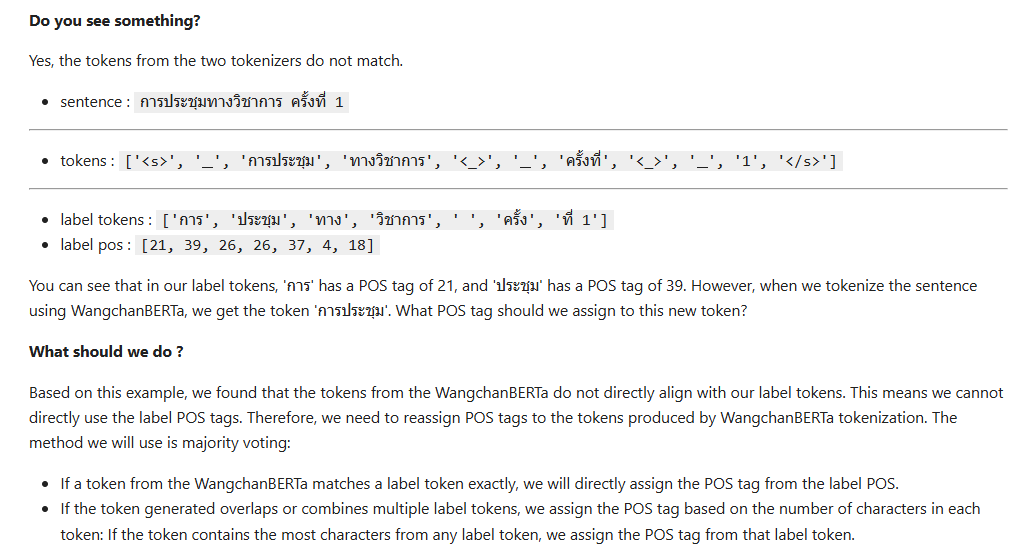

In [28]:
orchidl['train']

Dataset({
    features: ['id', 'label_tokens', 'pos_tags', 'sentence'],
    num_rows: 18500
})

In [56]:
def majority_vote_pos(example):
    # แก้ปัญหา 'ำ' ที่ WangchanBERTa preprocessing แยกเป็น 'ํ' + 'า'
    sentence = example["sentence"].replace("ำ", "ํา")  
    label_tokens = example["label_tokens"]
    label_pos = example["pos_tags"]

    # tokenize ประโยคด้วย tokenizer ของ WangchanBERTa
    tokens = tokenizer.tokenize(sentence, add_special_tokens=True)

    new_tokens = []
    new_labels = []

    for token in tokens:
        new_tokens.append(token)

        # ถ้า token เป็น special token หรือ <unk> ให้ ignore loss
        if token in tokenizer.all_special_tokens or token == tokenizer.unk_token:
            new_labels.append(-100)
            continue

        # majority voting: เลือก label token ที่ตรงกับตัวอักษรมากที่สุด
        max_overlap = 0
        max_pos = -100
        for lt, lp in zip(label_tokens, label_pos):
            overlap = len(set(token) & set(lt))  # นับตัวอักษรที่ซ้ำกัน
            if overlap > max_overlap:
                max_overlap = overlap
                max_pos = lp

        new_labels.append(max_pos)

    return {"tokens": new_tokens, "labels": new_labels}

In [57]:
tokenized_orchid = orchidl.map(majority_vote_pos)


Map:   0%|          | 0/18500 [00:00<?, ? examples/s]

Map: 100%|██████████| 4625/4625 [00:03<00:00, 1235.59 examples/s]


In [59]:
tokenized_orchid['train'][0]

{'id': '0',
 'label_tokens': ['การ', 'ประชุม', 'ทาง', 'วิชาการ', ' ', 'ครั้ง', 'ที่ 1'],
 'pos_tags': [21, 39, 26, 26, 37, 4, 18],
 'sentence': 'การประชุมทางวิชาการ ครั้งที่ 1',
 'tokens': ['<s>',
  '▁',
  'การประชุม',
  'ทางวิชาการ',
  '▁',
  'ครั้งที่',
  '▁',
  '1',
  '</s>'],
 'labels': [-100, -100, 39, 26, -100, 4, -100, 18, -100]}

In [60]:
example = tokenized_orchid["train"][0]
for i in example :
    print(i, ":", example[i])

id : 0
label_tokens : ['การ', 'ประชุม', 'ทาง', 'วิชาการ', ' ', 'ครั้ง', 'ที่ 1']
pos_tags : [21, 39, 26, 26, 37, 4, 18]
sentence : การประชุมทางวิชาการ ครั้งที่ 1
tokens : ['<s>', '▁', 'การประชุม', 'ทางวิชาการ', '▁', 'ครั้งที่', '▁', '1', '</s>']
labels : [-100, -100, 39, 26, -100, 4, -100, 18, -100]


In [61]:
# hard test case
example = tokenized_orchid["train"][1899]
for i in example :
    print(i, ":", example[i])

id : 1899
label_tokens : ['โดย', 'พิจารณา', 'จาก', 'พจนานุกรม', 'ภาษา', 'คู่', ' ', '(', 'bilingual transfer dictionary', ')']
pos_tags : [25, 39, 38, 26, 26, 5, 37, 37, 26, 37]
sentence : โดยพิจารณาจากพจนานุกรมภาษาคู่ (bilingual transfer dictionary)
tokens : ['<s>', '▁โดย', 'พิจารณาจาก', 'พจนานุกรม', 'ภาษา', 'คู่', '▁(', 'bi', 'ling', 'ual', '▁', 'trans', 'fer', '▁', 'di', 'ction', 'ary', ')', '</s>']
labels : [-100, 25, 39, 26, 26, 5, 37, 26, 26, 26, -100, 26, 26, -100, 26, 26, 26, 37, -100]


labels : [-100, 25, 39, 26, 26, 5, 37, 37, 26, 26, 26, 26, -100, 26, 26, 26, -100, 26, 26, 26, 37, -100]


In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)